<a href="https://colab.research.google.com/github/LeoFernanndes/notebooks/blob/master/titanic_data_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!git clone https://github.com/LeoFernanndes/functions
!pip install category_encoders

fatal: destination path 'functions' already exists and is not an empty directory.


In [54]:
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


url_train = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_%20train.csv'
url_test = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_test.csv'
url_dataframe_feature_engineering = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_feature_engineering.csv'

columns_order = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

train = pd.read_csv(url_train).reindex(columns_order, axis= 1)
test = pd.read_csv(url_test).reindex(columns_order.remove('Survived'), axis= 1)
feature_engineering = pd.read_csv(url_dataframe_feature_engineering)

dataframe = train.append(test, sort= False).set_index(np.arange(0,1309), columns_order)
backup = dataframe.copy()


dataframe['Embarked'] = dataframe['Embarked'].fillna(dataframe['Embarked'].mode()[0])
dataframe['Fare'] = dataframe['Fare'].fillna(dataframe['Fare'].mean())
dataframe['Age'] = dataframe['Age'].fillna(dataframe.groupby(by= ['Sex', 'Pclass'])['Age'].transform('mean'))
dataframe['Cabin'] = dataframe['Cabin'].fillna('Missing')
dataframe['Family_size'] = dataframe['Parch'] + dataframe['SibSp']
dataframe['Title'] = [name.split(', ')[1].split('.')[0] for name in dataframe['Name']]

def age_(x):
  if x < 21:
    return 1
  elif x < 25:
    return 2
  elif x < 30:
    return 3
  elif x < 40:
    return 4
  else:
    return 5

dataframe['Age_bins'] = dataframe['Age'].apply(age_)

def fare_(x):
  if x < 8:
    return 1
  elif x < 10:
    return 2
  elif x < 21:
    return 3
  elif x < 41:
    return 4
  else:
    return 5

dataframe['Fare_bins'] = dataframe['Fare'].apply(fare_)


feature_engineering['Survived'] = feature_engineering['Survived'].astype(int)


fe = feature_engineering.copy()
df = dataframe.copy()
"""
data_preprocessing.naive_data_preparation(df)
df_train = df.iloc[0:700]
df_validation = df.iloc[700:891]
df_test = df.iloc[891:]"""

'\ndata_preprocessing.naive_data_preparation(df)\ndf_train = df.iloc[0:700]\ndf_validation = df.iloc[700:891]\ndf_test = df.iloc[891:]'

In [55]:
dataframe

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Family_size,Title,Age_bins,Fare_bins
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,Missing,S,0.0,1,Mr,2,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.283300,C85,C,1.0,1,Mrs,4,5
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,Missing,S,1.0,0,Miss,3,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S,1.0,1,Mrs,4,5
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,Missing,S,0.0,0,Mr,4,2
5,6,3,"Moran, Mr. James",male,25.962264,0,0,330877,8.458300,Missing,Q,0.0,0,Mr,3,2
6,7,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.862500,E46,S,0.0,0,Mr,5,5
7,8,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.075000,Missing,S,0.0,4,Master,1,4
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.133300,Missing,S,1.0,2,Mrs,3,3
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.070800,Missing,C,1.0,1,Mrs,1,4


In [0]:
import category_encoders as ce
from sklearn.preprocessing import scale


categorical = ['Title', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Family_size', 'Embarked', 'Age_bins', 'Fare_bins']

for feature in categorical:
  count = ce.CountEncoder()
  df[feature + '_count'] = df[feature].astype('str')
  df[feature + '_count'] = count.fit_transform(df[feature + '_count'])
  
for feature in categorical:
  target = ce.TargetEncoder()
  df[feature + '_target'] = df[feature].astype('str')
  target.fit(df[feature + '_target'].iloc[:891], df['Survived'].iloc[:891])
  df[feature + '_target'] = target.transform(df[feature + '_target'])


categorical_ = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

for feature in categorical_:
  ohe = ce.OneHotEncoder()
  ohe.fit(df[feature].astype('str'))
  df = pd.concat([df, ohe.transform(df[feature])], axis= 1)


to_scale = ['Fare', 'Age']
for feature in to_scale:
  df[feature + '_scale'] = scale(df[feature])


In [0]:
#df.info()

In [58]:
fe.head().dtypes

Unnamed: 0       int64
Sex              int64
Ticket           int64
Age            float64
Fare           float64
Name             int64
PassengerId      int64
Title            int64
Title_n        float64
Cabin            int64
Pclass           int64
Fare_            int64
Pclass_          int64
Family           int64
Family_          int64
Age_             int64
SibSp            int64
Embarked         int64
Parch            int64
Survived         int64
dtype: object

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from functions import data_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier


data_preprocessing.naive_data_preparation(df)
df_train = df.iloc[0:700]
df_validation = df.iloc[700:891]
df_test = df.iloc[891:]
fe = feature_engineering.copy()


colunas1 = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

clf1 = LGBMClassifier()
result1 = cross_val_score(clf1, df_train[colunas1], df_train['Survived'], cv= 10)


colunas2 = ['Pclass', 'Sex_target', 'SibSp', 'Parch', 'Fare_scale', 'Embarked', 'Family_size',
       'Title', 'Age_scale']

clf2 = LGBMClassifier()
result2 = cross_val_score(clf2, df_train[colunas2], df_train['Survived'], cv= 10)

clf2.fit(df_train[colunas2], df_train['Survived'])
feat_imp_ = clf2.feature_importances_
feat_imp = pd.DataFrame({'feature': colunas2,
                         'importance': feat_imp_}).sort_values(by= ['importance'], ascending= False)


colunas3 = ['Fare_', 'Age_', 'Title_n', 'Pclass_', 'Family_', 'Cabin']

clf3 = LGBMClassifier()
result3 = cross_val_score(clf3, fe[colunas3], fe['Survived'], cv= 10)


print('ootb', result1.mean(), '\n',
      'fe', result2.mean(), '\n', 
      'best', result3.mean(), '\n',
      feat_imp)      

ootb 0.8057142857142857 
 fe 0.8114285714285714 
 best 0.7608044627128597 
        feature  importance
4   Fare_scale        1115
8    Age_scale         880
6  Family_size         120
5     Embarked         108
7        Title          88
0       Pclass          85
1   Sex_target          74
2        SibSp          63
3        Parch          32


In [60]:
df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived', 'Family_size',
       'Title', 'Age_bins', 'Fare_bins', 'Title_count', 'Pclass_count',
       'Sex_count', 'SibSp_count', 'Parch_count', 'Family_size_count',
       'Embarked_count', 'Age_bins_count', 'Fare_bins_count', 'Title_target',
       'Pclass_target', 'Sex_target', 'SibSp_target', 'Parch_target',
       'Family_size_target', 'Embarked_target', 'Age_bins_target',
       'Fare_bins_target', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_1',
       'Sex_2', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5',
       'SibSp_6', 'SibSp_7', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4',
       'Parch_5', 'Parch_6', 'Parch_7', 'Parch_8', 'Embarked_1', 'Embarked_2',
       'Embarked_3', 'Fare_scale', 'Age_scale'],
      dtype='object')

In [82]:
# 'Fare_', 'Age_', 'Title_n', 'Pclass_', 'Family_', 'Cabin', 'Survived'

colunas = ['Pclass_target', 'Sex_count', 'Fare_scale', 'Embarked_target', 'Family_size', 'Title', 'Age_scale', 'Survived']

fe_train = fe.iloc[:891].copy()
fe_test = fe.iloc[891:].copy()

classifiers = [AdaBoostClassifier(n_estimators=500),
               ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='gini',max_depth=5),
               XGBClassifier(n_estimators=500, nthread=-1, max_depth = 5, seed=1729),
               GradientBoostingClassifier(n_estimators=500),
               DecisionTreeClassifier(),
               AdaBoostClassifier(n_estimators=250),
               ExtraTreesClassifier(n_estimators=250, n_jobs=-1, criterion='gini',max_depth=5),
               XGBClassifier(n_estimators=250, nthread=-1, max_depth = 5, seed=1729),
               GradientBoostingClassifier(n_estimators=250),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               RandomForestClassifier(n_estimators= 100),
               RandomForestClassifier(n_estimators= 300),
               LGBMClassifier()]


for clf in classifiers:
  clf.fit(df_train[colunas[:-1]], df_train['Survived'])
  pred = clf.predict(df_validation[colunas[:-1]])
  model = str(clf).split('(')[0]
  
  accuracy_score_1 = accuracy_score(pred, df_validation[colunas[-1]])
  f1_score_1 = f1_score(pred, df_validation[colunas[-1]])

  print('{}, Accuracy: {}, f1_score: {}'.format(model, accuracy_score_1, f1_score_1))

AdaBoostClassifier, Accuracy: 0.8429319371727748, f1_score: 0.7887323943661971
ExtraTreesClassifier, Accuracy: 0.8534031413612565, f1_score: 0.791044776119403
XGBClassifier, Accuracy: 0.837696335078534, f1_score: 0.7862068965517242
GradientBoostingClassifier, Accuracy: 0.8534031413612565, f1_score: 0.8028169014084506
DecisionTreeClassifier, Accuracy: 0.8010471204188482, f1_score: 0.736111111111111
AdaBoostClassifier, Accuracy: 0.8481675392670157, f1_score: 0.7913669064748201
ExtraTreesClassifier, Accuracy: 0.8586387434554974, f1_score: 0.8
XGBClassifier, Accuracy: 0.837696335078534, f1_score: 0.7862068965517242
GradientBoostingClassifier, Accuracy: 0.8638743455497382, f1_score: 0.8142857142857144
DecisionTreeClassifier, Accuracy: 0.7958115183246073, f1_score: 0.7272727272727272
LinearDiscriminantAnalysis, Accuracy: 0.8167539267015707, f1_score: 0.7368421052631579
RandomForestClassifier, Accuracy: 0.8429319371727748, f1_score: 0.7916666666666666
RandomForestClassifier, Accuracy: 0.83246

Accuracy: 0.8691099476439791, f1_score: 0.8251748251748252


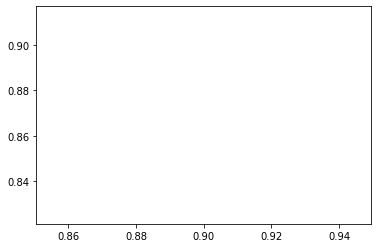

In [85]:
dataframe_stack_train = df.iloc[:700]
dataframe_stack_test = df.iloc[700:891]
dataframe_stack_classification = df.iloc[:891]
dataframe_stack_submit = df.iloc[891:]

df_stack_train = pd.DataFrame({'PassengerId': dataframe_stack_train['PassengerId']}).set_index(['PassengerId'])
df_stack_test = pd.DataFrame({'PassengerId': dataframe_stack_test['PassengerId']}).set_index(['PassengerId'])
df_stack_classification = pd.DataFrame({'PassengerId': dataframe_stack_classification['PassengerId']}).set_index(['PassengerId'])
df_stack_submit = pd.DataFrame({'PassengerId': dataframe_stack_submit['PassengerId']}).set_index(['PassengerId'])


classifiers = [AdaBoostClassifier(n_estimators=500),
               ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='gini',max_depth=5),
               XGBClassifier(n_estimators=500, nthread=-1, max_depth = 5, seed=1729),
               GradientBoostingClassifier(n_estimators=500),
               DecisionTreeClassifier(),
               AdaBoostClassifier(n_estimators=250),
               ExtraTreesClassifier(n_estimators=250, n_jobs=-1, criterion='gini',max_depth=5),
               XGBClassifier(n_estimators=250, nthread=-1, max_depth = 5, seed=1729),
               GradientBoostingClassifier(n_estimators=250),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               RandomForestClassifier(n_estimators= 100),
               RandomForestClassifier(n_estimators= 300),
               LGBMClassifier()]

classifiers = [LGBMClassifier()]


cv_splits = [0.05, 0.2, 0.4, 0.6, 0.8, 0.95]
cv_splits = [0.90]

x_axis = []
y_axis = []


for split in cv_splits:

  iterations = 20


  # training stage 
  for clf in classifiers:
    for n in range(iterations):  


      x_train, x_test, y_train, y_test = train_test_split(dataframe_stack_train[colunas[:-1]],
                                                          dataframe_stack_train[colunas[-1]], train_size= split, random_state= None)


      clf.fit(x_train, y_train)

      
      clf_ = clf.predict(dataframe_stack_test[colunas[:-1]])
      clf_dataframe_ = pd.DataFrame({n: clf_}, index= df_stack_test.index)
      df_stack_test = pd.concat([df_stack_test, clf_dataframe_], axis= 1)


  mean = df_stack_test.mean(axis= 1)
  mode = df_stack_test.mode(axis= 1)


  f1_score_ = f1_score(mode[0], dataframe_stack_test['Survived'])
  accuracy_score_ = accuracy_score(mode[0], dataframe_stack_test['Survived'])

  x_axis.append(split)
  y_axis.append(accuracy_score_)

  # submission classification stage
  for clf in classifiers:
    for n in range(iterations):  


      x_train, x_test, y_train, y_test = train_test_split(dataframe_stack_classification[colunas[:-1]],
                                                          dataframe_stack_classification[colunas[-1]], train_size= split, random_state= None)


      clf.fit(x_train, y_train)

      
      clf_ = clf.predict(dataframe_stack_submit[colunas[:-1]])
      clf_dataframe_ = pd.DataFrame({n: clf_}, index= df_stack_submit.index)
      df_stack_submit = pd.concat([df_stack_submit, clf_dataframe_], axis= 1)


  mean_submission = df_stack_submit.mean(axis= 1)
  mode_submission = df_stack_submit.mode(axis= 1)[0]


  submission = list(mode_submission.map({0.0: 0, 1.0: 1}))
  envio = pd.DataFrame({'PassengerId': dataframe_stack_submit['PassengerId'],
                        'Survived': submission}).set_index(['PassengerId'])

  from google.colab import files


  envio.to_csv('titanic_submission_5.csv')

  print('Accuracy: {}, f1_score: {}'.format(accuracy_score_, f1_score_))

  plt.plot(x_axis, y_axis)